In [1]:
import os

import cv2
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 999

In [2]:
base_meta_info = pd.read_csv("../../data/audio/train_meta.tsv", sep="\t")
test_meta_info = pd.read_csv("../../data/audio/test_meta.tsv", sep="\t")

In [3]:
base_meta_info

,trackid,artistid,archive_features_path
0,1,1,1/1/0/1.npy
1,2,2,2/2/0/2.npy
2,3,3,3/3/0/3.npy
3,4,4,4/4/0/4.npy
4,5,5,5/5/0/5.npy
...,...,...,...
167191,167192,6461,1/2/9/167192.npy
167192,167193,11929,9/3/9/167193.npy
167193,167194,18190,0/4/9/167194.npy
167194,167195,3080,0/5/9/167195.npy


In [4]:
# vc = sorted(base_meta_info.artistid.value_counts().values, reverse=True)
# plt.bar(range(len(vc)), vc)

# split data

In [7]:
def train_val_split(dataset, val_size=0.1):  # Сплит по artistid
    dataset["stage"] = "train"
    artist_ids = dataset["artistid"].unique()
    _, val_artist_ids = train_test_split(artist_ids, test_size=val_size)
    dataset.loc[dataset.artistid.isin(val_artist_ids), "stage"] = "test"
    return dataset

dataset_with_stages = train_val_split(base_meta_info, 0.1)

In [8]:
dataset_with_stages.to_csv("../../data/audio/train_meta_with_stages.tsv", sep="\t", index=False)

# Filter dataset

In [9]:
MIN_SAMPLES_PER_CLASS = 10
base_artists_cnt = dataset_with_stages.artistid.nunique()
counts = dataset_with_stages.artistid.value_counts()
selected_classes = counts[counts >= MIN_SAMPLES_PER_CLASS].index
meta_info = dataset_with_stages.loc[dataset_with_stages.artistid.isin(selected_classes)].reset_index(drop=True)

print(f"BASE:     Classes Count: {base_artists_cnt} Data size: {dataset_with_stages.shape[0]}")
print(f"FILTERED: Classes Count: {len(selected_classes)} Data size: {meta_info.shape[0]}")

BASE:     Classes Count: 18468 Data size: 167196
FILTERED: Classes Count: 15002 Data size: 150020


In [11]:
meta_info.to_csv("../../data/audio/train_meta_with_stages_balanced.tsv", sep="\t", index=False)

# Check embeddings

In [7]:
emb_path = meta_info.iloc[1].archive_features_path
emb = np.load(os.path.join("../../data/audio/train_features", emb_path))

In [6]:
emb_shapes = [
    np.load(os.path.join("../../data/audio/test_features", emb_path)).shape[1]
    for emb_path in tqdm(test_meta_info.archive_features_path)
]

100%|██████████| 41377/41377 [00:07<00:00, 5191.41it/s]


In [7]:
max(emb_shapes), min(emb_shapes), np.mean(emb_shapes)

(81, 61, 80.95956690915243)

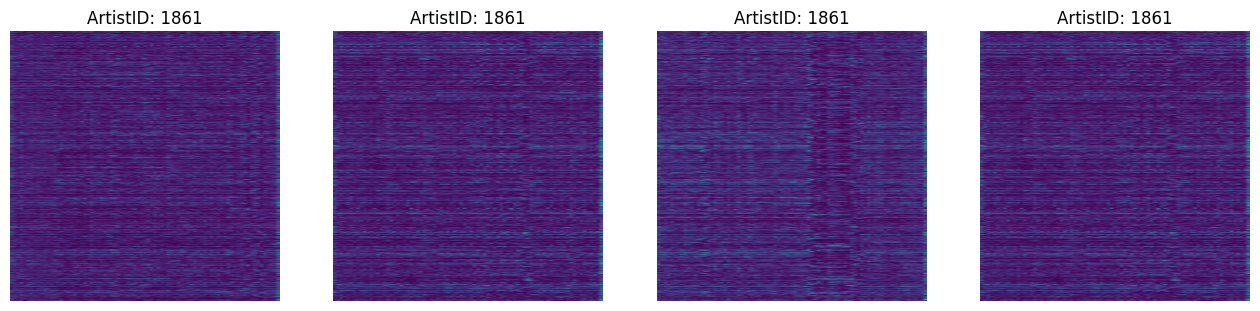

In [99]:
n_embs = 4
artistid = np.random.choice(meta_info.artistid.unique())
emb_paths = np.random.choice(meta_info[meta_info.artistid == artistid].archive_features_path, n_embs)
embs = [np.load(os.path.join("../../data/audio/train_features", ep)) for ep in emb_paths]

fig, axes = plt.subplots(1, n_embs, figsize=(16, 8))
for i in range(n_embs):
    axes[i].imshow(cv2.resize(embs[i], (512, 512)))
    axes[i].axis('off')
    axes[i].set_title(f"ArtistID: {artistid}")

In [105]:
emb = embs[0]
emb_len = emb.shape[1]

out = torch.nn.functional.pad(torch.from_numpy(embs[0]), (1, -1), "constant", 0)

In [107]:
out.shape

torch.Size([512, 81])

# Datsets

In [1]:
import sys
sys.path.append("../")

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

from getter import Getter

getter = Getter()

def load_cfg(cfg_path):
    initialize(config_path=cfg_path, job_name="cfg")
    cfg = compose(
        config_name="default",
        overrides=[
            "experience.seed=42",
            "experience.data_dir=/home/and/projects/hacks/yandex_cup_2022/data/audio/train_features",
            "experience.experiment_name=EXP",
        ]
    )
    return cfg

In [3]:
cfg = load_cfg("../config")

/tmp/ipykernel_193149/2332200083.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=cfg_path, job_name="cfg")


In [4]:
transform_cfg = cfg.transform
dataset_cfg = cfg.dataset
test_transform = getter.get_transform(transform_cfg.test)
ds = getter.get_dataset(test_transform, 'test', dataset_cfg)
len(ds)

15010

# Model

In [15]:
from torch import nn
from torch.nn import functional as F
from torchvision import models

device = 'cpu'

class BasicNet(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.output_features_size = output_features_size
        self.conv_1 = nn.Conv1d(512, output_features_size, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(
            output_features_size, output_features_size, kernel_size=3, padding=1
        )
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(
            output_features_size, output_features_size, kernel_size=3, padding=1
        )
        self.conv_4 = nn.Conv1d(
            output_features_size, output_features_size, kernel_size=3, padding=1
        )

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = self.conv_4(x).mean(axis=2)
        return x


class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z

In [25]:
encoder = models.resnet18()
encoder.conv1 = nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)
print(encoder)
encoder.fc = torch.nn.Linear(512, 512)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
features = torch.zeros((2, 1, 512, 81))
encoder(features).shape

torch.Size([2, 512])

# Check Losses

In [1]:
import sys
sys.path.append("../")

import losses

In [9]:
criterion = losses.CalibrationLoss()
params = [p for p in criterion.parameters()]
params

[]

In [11]:
criterion = losses.ArcFaceLoss(num_classes=10, embedding_size=256)
params = [p for p in criterion.parameters()]
params

[Parameter containing:
 tensor([[ 0.8872,  0.7793,  0.0191,  ...,  0.2951, -0.4093,  0.3999],
         [ 1.3504,  1.0412, -1.1473,  ..., -1.8358,  0.8278,  0.8461],
         [ 2.3031, -0.6060,  1.8189,  ..., -2.5422,  0.2872, -0.1758],
         ...,
         [ 0.4370,  1.7473,  1.7534,  ...,  1.0836, -0.8075, -1.6954],
         [ 0.4425,  1.2961, -0.7129,  ...,  0.3228,  1.1673, -1.5148],
         [ 0.8601, -0.9802, -0.9062,  ...,  2.0585,  0.9719,  0.9269]],
        requires_grad=True)]

In [12]:
criterion = losses.SupAP()
params = [p for p in criterion.parameters()]
params

[]

In [15]:
criterions = [losses.SupAP(), losses.ArcFaceLoss(num_classes=10, embedding_size=256), losses.CalibrationLoss()]
for crit in filter(lambda crit: len([p for p in crit.parameters()]) > 0, criterions):
    print(crit)

ArcFaceLoss(
  (distance): CosineSimilarity()
  (reducer): MeanReducer()
  (cross_entropy): CrossEntropyLoss()
)
